## Cel pracy

Celem projektu jest znalezienie potencjalnych darczyńców w zbiorze danych, który jest spisem powszechnym ludności w USA z 1994 roku. W ramach projektu wykorzystam różnego rodzaju algorytmy uczenia maszynowego oprate na uczeniu nadzorowanym w celu zaprognozowania dochodu osób z subsetu. W kolejnym etapie wybiorę algorytm o największej skuteczności/precyzji. 
Zakładam, że potencjalni darczyńcy to osoby, która zarabiają ponad 50 000 $. Podstawą pracy będzie eksploracja danych i znalezienie cech, które w najwięszym stopniu determinują osiągany dochód. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import precision_recall_curve, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

pd.options.display.float_format = "{:.3f}".format
pd.set_option('display.max_columns',100)

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
sns.set(style='white')

In [2]:
# Funckje

def counts_pct(category,data):
    '''Funkcja, która zwraca dla tanej kategori liczbe wartości, oraz wartość procentową'''
    base = data[category].value_counts()
    pct = base/data[category].shape[0] * 100
    joined = pd.concat([base,pct],axis=1)
    joined.columns = [str(category),str(category) + ' %']
    return joined


def annotate(ax,s="%.2f",suffix=''):
    for p in ax.patches:
        ax.annotate(s % p.get_height() + suffix, 
                 (p.get_x() + p.get_width() / 2,
                  p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
def despine(rot=0):
    sns.despine(left=True)
    plt.xticks(rotation = rot);
    plt.xlabel('');
    plt.ylabel('');

In [3]:
data = pd.read_csv('census.csv')

In [4]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.000,Never-married,Adm-clerical,Not-in-family,White,Male,2174.000,0.000,40.000,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000,0.000,13.000,United-States,<=50K
2,38,Private,HS-grad,9.000,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000,0.000,40.000,United-States,<=50K
3,53,Private,11th,7.000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000,0.000,40.000,United-States,<=50K
4,28,Private,Bachelors,13.000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000,0.000,40.000,Cuba,<=50K


In [5]:
data.shape

(45222, 14)

## Dataset Informacje

Zbiór danych pochodzi ze strony https://archive.ics.uci.edu/ml/datasets/census+income

Jest to spis powszechny ludności w USA z 1994 roku, w którym mamy cechy społeczno ekonomiczne każdej osoby oraz informacje o dochodzie. 

Zbiór danych liczy 45222 wiersze oraz 14 cech.


### Zmienne  

__age:__ Age  
__workclass__: Working Class (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)  
__education_level__: Level of Education (Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)  
__education-num__: Number of educational years completed  
__marital-status__: Marital status (Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse)  
__occupation:__ Work Occupation (Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces)  
__relationship__: Relationship Status (Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried)  
__race:__ Race (White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)  
__sex:__ Sex (Female, Male)  
__capital-gain:__ Monetary Capital Gains  
__capital-loss:__ Monetary Capital Losses  
__hours-per-week:__ Average Hours Per Week Worked  
__native-country:__ Native Country (United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands)  

__income:__ Income Class (<=50K, >50K) - Target  

In [6]:
data.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Nie mamy w naszym zbiorze danych, rzadnych brakujących danych. Więc możemy przejść do ekslporacji danych

### Eksploracja i wizualizacja danych

In [7]:
counts_pct(category='income',data=data)

,income,income %
<=50K,34014,75.216
>50K,11208,24.784


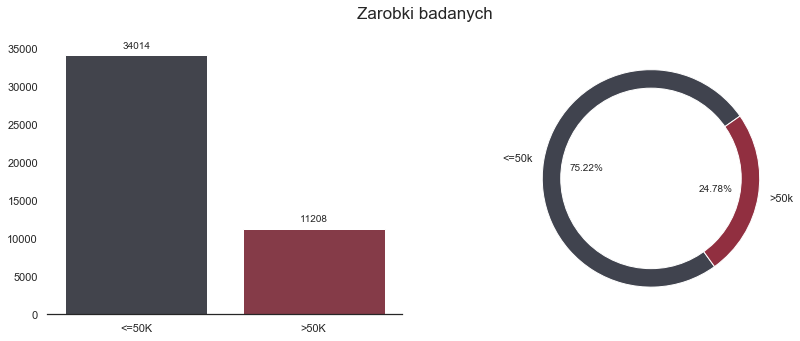

In [8]:
f,ax = plt.subplots(1,2,figsize=(14,5))
fig1 = sns.barplot(y='income', x=counts_pct(category='income',data=data).index 
                   ,data= counts_pct(category='income',data=data)
                  ,palette=['#40434E','#912F40'],ax=ax[0])
fig1.set_ylabel('');
annotate(fig1,s="%.0f",suffix='')
despine()

my_circle=plt.Circle( (0,0), 0.83, color='white')
names=['<=50k','>50k']
size=data['income'].value_counts().tolist()
plt.pie(size, labels=names, colors=['#40434E','#912F40'],autopct='%1.2f%%',startangle=35)
p=plt.gcf()
p.gca().add_artist(my_circle);
plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');
plt.suptitle('Zarobki badanych', fontsize=17);

Widzimy, ze w naszym zbiorze danych 75% stanowią, osoby zarabiające mniej niż 50 000 USD, pozostałe 25 % zarabia więcej niż 50 000 USD

### Przygotowanie danych

Jednym z podstawowych działań przed przystąpieniem do budowania modelu jest wstępne przetworzenie danych. Etap ten obejmuje m.in czyszczenie danych, formatowanie danych, zmianę struktury danych itd. 
Zbiór danych może czasem zawierać cechy, których dytrybucja oscyluje wokół danego punktu (liczby, wartości) jednak może również zawierać znaczną część wartości, które leżą daleko od tego punktu. Algorytmy mogą być wrażliwe na takie rozkłady wartości i mogą osiągać gorsze wyniki. W takim wypadku zazwyczaj stosuje się metody normalizacji. 

Czym jest skośność ? 

Skośność jest miarą asymetrii obserwowanych wyników. Informuje nas o tym jak wyniki dla danej zmiennej kształtują się wokół średniej. Czy większość zaobserwowanych wyników jest z lewej strony średniej, blisko wartości średniej czy z prawej strony średniej? Innymi słowy, czy w naszym zbiorze obserwacji więcej jest wyników, które są niższe niż średnia dla całej grupy, wyższe czy równe średniej?

![Image of skośność](https://consider.pl/wp-content/uploads/2014/11/kurtoza_skosnosc.jpg)

1. Rozkład normalny jest idealnie symetryczny. Występuje tu zależność __Średnia= Mediana= Dominanta__ Oznacza to, że wartość średnia dzieli rozkład dokładnie na pół i jest też najczęściej występującą wartością.

2. Rozkład prawoskośny cechuje się natomiast długim tzw. „ogonem” z prawej strony rozkładu. __Średnia > Mediana > Dominanta__
Oznacza to, że w próbie badawczej jest więcej wyników poniżej średniej.

3. W rozkładzie lewoskośnym występuje natomiast długi ogon z lewej strony rozkładu. . Zachodzi w nim zależność: __Średnia < Mediana < Dominanta__

Poza skośnością rozkładu bardzo ważna jest również kurtoza określająca drugi wymiar zmiany rozkładu, jego spłaszczenie lub wysmuklenie. Kurtoza wraz ze skośnością są miarami pozwalającymi określić czy rozkład jest zgodny z rozkładem normalnym lub czy występują istotne różnice między badanym rozkładem a rozkładem normalnym.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


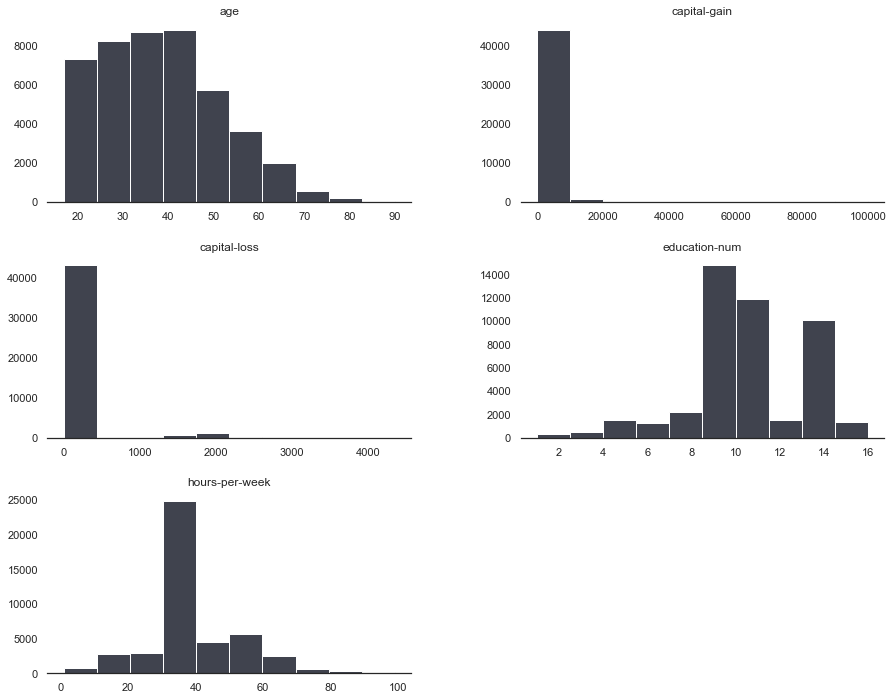

In [10]:
# kategorie capital-gain, capital-loss , hours-per-week ,   age  , education-num
features_sk = ['capital-gain','capital-loss','age','education-num','hours-per-week']

data[features_sk].hist(figsize=(15,12),grid=False,color='#40434E');
despine()

In [11]:
data[features_sk].skew()

capital-gain     11.789
capital-loss      4.516
age               0.533
education-num    -0.311
hours-per-week    0.341
dtype: float64

W przypadku capital-gain i capital-loss mamy doczyniennia z asymtrią i dużą skośnością prawostronną.Skośne rozkłady danych mogą sprawić, że algorytm będzie słabszy. Powinniśmy dokonać normalizacji danych. 

In [12]:
data[['capital-gain','capital-loss']] = data[['capital-gain','capital-loss']].apply(lambda x: np.log(x+1))

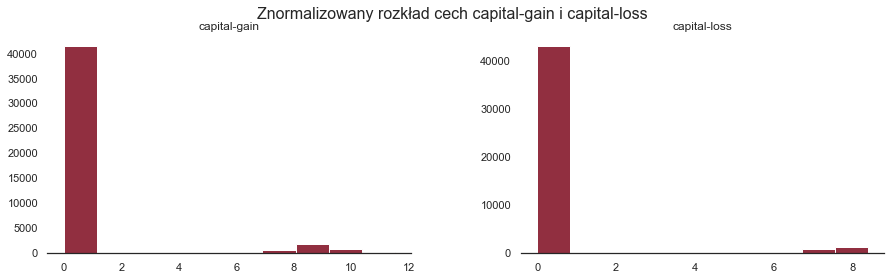

In [13]:
data[['capital-gain','capital-loss']].hist(figsize=(15,4),grid=False,color='#912F40');
despine()
plt.suptitle('Znormalizowany rozkład cech capital-gain i capital-loss',fontsize=16);

#### Normalizacja cech numerycznych

Normalizacja jest techniką stosowaną w celu przygotowywania danych do uczenia maszynowego. Celem normalizacji jest zmiana wartości kolumn numerycznych w zbiorze danych na wspólną skalę, bez zniekształcania różnic w zakresach wartości.
Normalizacja typu MinMaxScaler odnosi się do przeskalowania rzeczywistych cech numerycznych do zakresu 0 i 1 (lub -1 do 1)
Normalizacja jest szczególnie przydatna, w przypadku gdy dane wejściowe mają różne skale. 


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[features_sk] = scaler.fit_transform(data[features_sk])
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301,State-gov,Bachelors,0.800,Never-married,Adm-clerical,Not-in-family,White,Male,0.667,0.000,0.398,United-States,<=50K
1,0.452,Self-emp-not-inc,Bachelors,0.800,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000,0.000,0.122,United-States,<=50K
2,0.288,Private,HS-grad,0.533,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000,0.000,0.398,United-States,<=50K
3,0.493,Private,11th,0.400,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000,0.000,0.398,United-States,<=50K
4,0.151,Private,Bachelors,0.800,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000,0.000,0.398,Cuba,<=50K


Zazwyczaj algorytmy uczenia się oczekują, że dane wejściowe będą numeryczne, co wymaga konwersji cech nienumerycznych (zwanych zmiennymi kategorialnymi). Jednym z popularnych sposobów konwersji zmiennych kategorialnych jest użycie encodingu „one-hot”. W ten sposób tworzymy zmienną „dummy” dla każdej możliwej kategorii dla każdej cechy nienumerycznej.

In [15]:
target = data['income'].apply(lambda x: 0 if x=='<=50K' else 1)
features = pd.get_dummies(data.drop('income',axis=1))

In [16]:
features

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 10th,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,...,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301,0.800,0.667,0.000,0.398,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.452,0.800,0.000,0.000,0.122,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.288,0.533,0.000,0.000,0.398,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.493,0.400,0.000,0.000,0.398,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.151,0.800,0.000,0.000,0.398,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219,0.800,0.000,0.000,0.398,0,0,1,0,


Po przekształceniu wszystkich zmiennych kategorialnych i znormalizowaniu wszystkich cech liczbowych musimy podzielić nasze dane na zestawy szkoleniowe i testowe. Wykorzystamy 80% danych do szkolenia, a 20% do testów


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size = 0.2, random_state = 42) 

In [18]:
X_train.shape

(36177, 103)

In [19]:
X_test.shape

(9045, 103)

### Budowanie modeli

Algorytmy uczenia nadzorowanego, które użyjemy do zbudowania modeli predykcyjnych: 
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Gaussian Naive Bayes

Prosty klasyfikator probabilistyczny. Naiwne klasyfikatory bayesowskie są oparte na założeniu o wzajemnej niezależności predyktorów (zmiennych niezależnych). Często nie mają one żadnego związku z rzeczywistością i właśnie z tego powodu nazywa się je naiwnymi. Bardziej opisowe jest określenie – „model cech niezależnych”. Pomimo ich naiwnego projektowania i bardzo uproszczonych założeń, w wielu rzeczywistych sytuacjach naiwne klasyfikatory Bayesa często pracują dużo lepiej, niż można było tego oczekiwać.

Nazywa się to naiwny klasyfikator bayesowski , ponieważ obliczenia prawdopodobieństw dla każdej hipotezy są uproszczone, tak aby wogóle były wykonalne. Zamiast próbować obliczyć wartości każdej wartości atrybutu P (d1, d2, d3 | h), zakłada się, że są one warunkowo niezależne z uwagi na wartość docelową i obliczane jako P (d1 | h) * P (d2 | H) i tak dalej. Jest to bardzo naiwne założenie, które jest mało prawdopodobne w rzeczywistych danych, tzn. ze atrybuty nie wchodzą w interakcje. Niemniej jednak podejście to działa zaskakująco dobrze z danymi, w przypadku których to założenie nie ma zastosowania.

Zelety modelu są takie, że jest prosty i szybki i osiąga przyzwoite rezultaty przy niewielkim dostrajaniu hyperparametrów. Dodatkowo nie potrzebuje dużej ilości danych, żeby dość dobrze zostać wytrenowanym. Słabość modelu jest taka, że bardzo mocno zakłada, ze cechy są od siebie niezależne. 
Najlepszym zastosowaniem tego algorytmu z dziedziny "text learningu"


więcej: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn


In [20]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
nb_model = bayes.fit(X_train, y_train)
nb_prediction=nb_model.predict(X_test)

In [21]:
cnf_matrix_nb = confusion_matrix(y_test, nb_prediction)
print('Skuteczność dla modelu Naive Bayes: ', round(accuracy_score(y_test, nb_prediction),4)*100 , ' %')

Skuteczność dla modelu Naive Bayes:  62.89  %


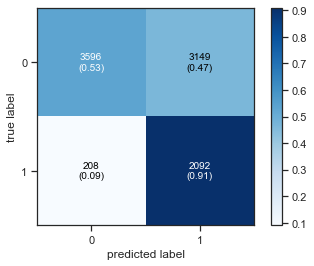

In [22]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_nb,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [23]:
print(classification_report(y_test, nb_prediction))

              precision    recall  f1-score   support

           0       0.95      0.53      0.68      6745
           1       0.40      0.91      0.55      2300

    accuracy                           0.63      9045
   macro avg       0.67      0.72      0.62      9045
weighted avg       0.81      0.63      0.65      9045



### DecisionTree 

Drzewa decyzyjne mogą być wykorzystywane zarówno do problemów klasyfikacji oraz regresji w przypadku niektórych danych o hierarchicznej strukturze. Drzewa decyzyjne wykorzystują uczenie maszynowe do zidentyfikowania głównych czynników, które powodują podział naszej klasy. Drzewa decyzyjne potrafią przewidzieć klasę na podstawie na podstawie danych wejściowych, które są poddawane wielu rozróżniających (dzielących) pytań. Pytania te mają formę tak/nie. Każde pytanie prowadzi do następnego pytania lub do końca drzewa. W przypadku drzewa decyzyjnego mamy doczynienia z kilkoma ważnymi pojęciami tj.
__klasa__ - w przypadku modeli klasyfikacyjneych są to różne kategorie w ramach, których przyporządkujemy naszą obserwację. Np. możemy przyporządkować klienta do kategorii dobry, zły i normalny.


Drzewo decyzyjne buduje się w sposób rekurencyjny od korzenia do liścia, metodą "dziel i zwyciężaj". Ogólna idea algorytmu indukcji drzewa jest następująca:

1. Drzewo zaczyna od pojedynczego węzła reprezentującego cały zbiór treningowy.
2. Jeżeli wszystkie przykłady należą do jednej klasy decyzyjnej, to zbadany węzeł staje się liściem i jest on etykietowany tą decyzją.
3. W przeciwnym przypadku algorytm wykorzystuje miarę entropii (funkcja przyrostu informacji) jako heurystyki do wyboru atrybutu, który najlepiej dzieli zbiór przykładów treningowych.
4. Dla każdego wyniku testu tworzy się jedno odgałęzienie i przykłady treningowe są odpowiednio rozdzielone do nowych węzłów (poddrzew).
5. Algorytm działa dalej w rekurencyjny sposób dla zbiorów przykładów przydzielonych do poddrzew.
6. Algorytm kończy się, gdy kryterium stopu jest spełnione.

Najczęściej stosowany algorytm podczas konstruowania drzew decyzyjnych jest znany jako ID3. Algorytm ID3 wykorzystuje dwa pojęcia znane jako „entropia” i „pozyskiwanie informacji” do zaprojektowania drzewa decyzyjnego. Drzewa decyzyjne próbują podzielić zestaw danych w taki sposób, aby dane obecne w każdej grupie były jak najbardziej do siebie podobne, podczas gdy dane obecne w jednej grupie były tak różne od danych obecnych w innych grupach, jak to możliwe . Aby to osiągnąć, korzystamy z koncepcji Entropii i pozyskiwania informacji

__Entropia:__ zazwyczaj termin „entropia” jest używany w odniesieniu do miary zanieczyszczenie zbioru ciągów uczących. W przypadku drzew decyzyjnych entropię można rozumieć jako miarę jednorodności próbki grupy danych. Zwykle entropia jest obliczana w skali od 0 do 1. Entropia 0 oznacza, że dane mają minimalne zaburzenia (jednorodne), podczas gdy entropia 1 (lub wysoka wartość entropii) wskazuje, że istnieje duża niejednorodność w danych.
- Entropia = 0 - jeśli wszystkie rozpatrywane przykłady należą do tej samej grupy.
- Entropia = 1 - jeśli grupa zawiera tyle samo pozytywnych i negatywnych przykładów.
- Entropia < 1 - jeśli liczby pozytywnych i negatywnych przykładów nie są sobie równe.


__Information Gain__

Przyrost informacji może być rozumiany jako oczekiwane zmniejszenie entropii spowodowane znajomością wartości jednego z
atrybutów. Przyrost informacji można rozumieć jako miarę spadku liczby zaburzeń. W drzewie decyzyjnym, w dowolnym węźle, nasz model wirtualnie dzieli dane na podstawie wszystkich możliwych atrybutów, których można użyć do podzielenia danych. Za każdym razem, gdy dokonujemy podziału na podstawie atrybutu, entropie dwóch utworzonych podzbiorów danych są obliczane i dodawane proporcjonalnie, aby uzyskać całkowitą entropię podziału. Ta całkowita entropia podziału jest następnie odejmowana od entropii danych obecnych w tym węźle przed podziałem, aby uzyskać jak największy przyrost informacji dla tego podziału.
Po uzyskaniu przyrostu informacji po podzieleniu danych według wszystkich możliwych atrybutów, znajdujemy atrybut, który prowadzi do najwyższego przyrostu informacji, i wykorzystujemy go do sformułowania pytania i podziału naszych danych.


In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train, y_train)
dt_prediction=dt_model.predict(X_test)
cnf_matrix_dt = confusion_matrix(y_test, dt_prediction)
print('Skuteczność dla modelu DecissionTree: ', round(accuracy_score(y_test,dt_prediction),4)*100 , ' %')

Skuteczność dla modelu DecissionTree:  82.26  %


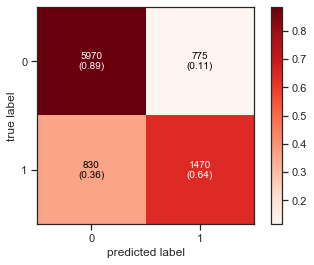

In [25]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_dt,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='Reds')

In [26]:
print(classification_report(y_test, dt_prediction))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6745
           1       0.65      0.64      0.65      2300

    accuracy                           0.82      9045
   macro avg       0.77      0.76      0.76      9045
weighted avg       0.82      0.82      0.82      9045



###  Random Forest
Jednym z najleszych i najczęściej stosowanych metod klasyfikacji jest RandomForestClassifier
Losowy las składa się z dużej liczby pojedynczych drzew decyzyjnych, które działają jako zespół. Każde pojedyncze drzewo w losowym lesie wyrzuca prognozę klasy, a klasa z największą liczbą głosów staje się prognozą naszego modelu

To   metodaklasyfikacji  (i  regresji)  polegająca  na  tworzeniu  wielu  drzew decyzyjnych  na  podstawie  losowego  zestawu  danych.  Idea  tego  algorytmu polega  na  zbudowaniu  konsylium  ekspertów  z  losowych  drzew  decyzyjnych, gdzie w odróżnieniu od klasycznych drzew decyzji, losowe drzewa budowane są na  zasadzie, iż  podzbiór  analizowanych  cech  w  węźle dobierany  jest losowo. Ponadto, poszczególne drzewa  z  losowych  lasów  drzew  budowane  są zgodnie zkoncepcją Bugging

Koncepcja  Bugging polega  na  budowie  ekspertów  dla  podzbioru zadań. W tym przypadku, ze wszystkich problemów do rozwiązania losowany jest ze zwracaniem podzbiór problemów a następnie dla tego podzbioru szukany  jest ekspert. W algorytmie tym z całego zbioru danych uczących losowany jest podzbiór (losowanie ze zwracaniem) i dla tego podzbioru budowany jest model predykcyjny, następnie po  raz  kolejny  ze  zwracaniem  losowany  jest  inny  podzbiór  wektorów idla niego budowany jest kolejny model. Całość powtarzana jest k krotnie a na koniec wszystkie zbudowane modele użyte są do głosowania.


In [27]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(n_jobs=4, n_estimators = 100,
                             criterion='gini',
                             verbose=False)

rfc_model = model_rfc.fit(X_train, y_train)
rfc_prediction=rfc_model.predict(X_test)
cnf_matrix_rfc = confusion_matrix(y_test, rfc_prediction)
print('Skuteczność dla modelu RandomForest: ', round(accuracy_score(y_test,rfc_prediction),4)*100 , ' %')

Skuteczność dla modelu RandomForest:  84.63000000000001  %


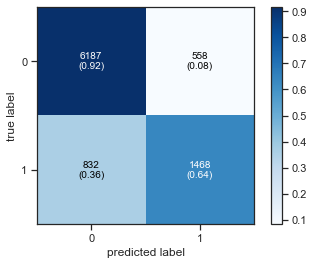

In [28]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_rfc,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='Blues')

In [29]:
print(classification_report(y_test, rfc_prediction))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6745
           1       0.72      0.64      0.68      2300

    accuracy                           0.85      9045
   macro avg       0.80      0.78      0.79      9045
weighted avg       0.84      0.85      0.84      9045



### Model SVC - Support Vector Classifier
Model ten jest szeroko stosowany w celach klasyfikacji. SVC to klasyfikator formalnie zdefiniowany przez oddzielającą hiperpłaszczyznę. Innymi słowy, biorąc pod uwagę oznaczone dane treningowe (uczenie nadzorowane), algorytm generuje optymalną hiperpłaszczyznę, która kategoryzuje nowe przykłady. W dwóch wymiarach przestrzennych hiperpłaszczyzna jest linią dzielącą płaszczyznę na dwie części, gdzie klasy leżą po obu stronach. Aby oddzielić dwie klasy punktów danych, można wybrać wiele możliwych hiperpłaszczyzn. Naszym celem jest znalezienie płaszczyzny, która ma maksymalny margines, tj. Maksymalną odległość między punktami danych obu klas

In [30]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
predict_svc = svc.predict(X_test)
cnf_matrix_svc = confusion_matrix(y_test, predict_svc)
print('Skuteczność dla modelu SVC: ', round(accuracy_score(y_test,predict_svc),4)*100 , ' %')

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Skuteczność dla modelu SVC:  83.74000000000001  %


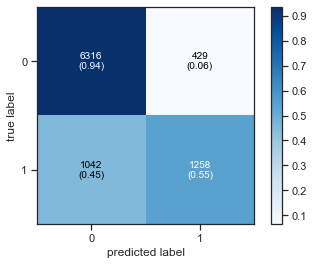

In [31]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_svc,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [32]:
print(classification_report(y_test, predict_svc))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6745
           1       0.75      0.55      0.63      2300

    accuracy                           0.84      9045
   macro avg       0.80      0.74      0.76      9045
weighted avg       0.83      0.84      0.83      9045



### K najbliższych sąsiadów - KNeighborsClassifier
KNN - jeden z algorytmow nadzorowanego uczenia maszynowego to taki, który polega na danych wejściowych oznaczonych etykietą w celu nauczenia się funkcji, która wytwarza odpowiednie dane wyjściowe po otrzymaniu nowych nieznakowanych danych.

Metoda K Najbliższych Sąsiadów (k-Nearest Neighbors) należy do grupy algorytmów leniwych (lazy algorithms), czyli takich, które nie tworzą wewnętrznej reprezentacji danych uczących, lecz szukają rozwiązania dopiero w momencie pojawienia się wzorca testującego, np. do klasyfikacji. Przechowuje wszystkie wzorce uczące, względem których wyznacza odległość wzorca testowego. Algorytm regresji nieparametrycznej używany w statystyce do prognozowania wartości pewnej zmiennej losowej). Leniwe uczenie oznacza, że ​​algorytm nie dokonuje uogólnień. Oznacza to, że korzystanie z tej metody wymaga niewielkiego szkolenia. Z tego powodu wszystkie dane szkoleniowe są również wykorzystywane do testowania podczas korzystania z KNN.

Algorytm KNN zakłada, że ​​podobne rzeczy istnieją w bliskiej odległości. Innymi słowy, podobne rzeczy są blisko siebie.

KNN jest Nieparametryczny - oznacza, że ​​nie przyjmuje żadnych założeń. Model składa się całkowicie z danych, które są mu przekazywane, zamiast zakładać, że jego struktura jest normalna.

KNN działa z powodu głęboko zakorzenionych teorii matematycznych, których używa. Przy wdrażaniu KNN, pierwszym krokiem jest przekształcenie punktów danych na wektory cech lub ich wartość matematyczną. Algorytm działa następnie poprzez znalezienie odległości między wartościami matematycznymi tych punktów. Najczęstszym sposobem znalezienia tej odległości jest odległość euklidesowa.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc_model = knc.fit(X_train, y_train)
knc_prediction=knc_model.predict(X_test)
cnf_matrix_knc = confusion_matrix(y_test, knc_prediction)
print('Skuteczność dla modelu KNeighbors: ', round(accuracy_score(y_test,knc_prediction),4)*100 , ' %')

Skuteczność dla modelu KNeighbors:  82.69999999999999  %


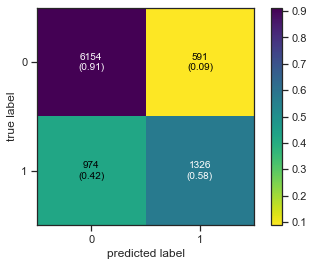

In [34]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_knc,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='viridis_r')

In [35]:
print(classification_report(y_test, knc_prediction))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      6745
           1       0.69      0.58      0.63      2300

    accuracy                           0.83      9045
   macro avg       0.78      0.74      0.76      9045
weighted avg       0.82      0.83      0.82      9045



### Regresja Logistyczna (Logistic Regression Classifier)

Regresja logistyczna to technika uczenia statystycznego skategoryzowana w metodach „nadzorowanego” uczenia maszynowego (ML) dedykowanych do zadań „klasyfikacji”. Zyskał wysoką popularność i reputację przez ostatnie dwie dekady. Popularność tej metody dotyczy szczególnie sektora finansowego, ze względu na swoją doskonałą zdolność przewidywania, że dany kredytobiorca nie zapłaci przyszłej raty. Model regresji logistycznej jest szczególnym przypadkiem uogólnionego modelu liniowego. Znajduje zastosowanie, gdy zmienna zależna jest dychotomiczna, to znaczy przyjmuje tylko dwie wartości takie jak na przykład sukces lub porażka, wystąpienie lub brak pewnej jednostki chorobowej, kobieta lub mężczyzna. W zapisie matematycznym wartości te reprezentowane są jako 1 i 0. Regresja logistyczna to metoda statystyczna służąca do analizy, czy jedna lub więcej zmiennych niezależnych determinuje wynik (w których są tylko dwa możliwe wyniki). Innymi słowy, przewiduje, czy coś jest Prawdą czy Fałszem. Regresja logistyczna - Jest to algorytm klasyfikacji, który jest używany, gdy zmienna odpowiedzi jest kategoryczna. Ideą regresji logistycznej jest znalezienie związku między cechami a prawdopodobieństwem określonego wyniku. Na przykład. Kiedy musimy przewidzieć, czy uczeń zda egzamin, czy nie zda egzaminu, gdy podana jest liczba godzin spędzonych na studiowaniu, zmienna odpowiedzi ma dwie wartości: pozytywny i negatywny.

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs') 
model_lr = lr.fit(X_train, y_train)
lr_prediction=model_lr.predict(X_test)
cf_lr = confusion_matrix(y_test, lr_prediction)
print('Skuteczność dla Regresji Logistycznej: ', round(accuracy_score(y_test,lr_prediction),4)*100 , ' %')

Skuteczność dla Regresji Logistycznej:  84.54  %


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


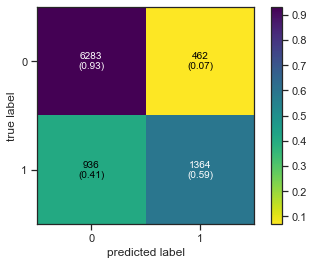

In [37]:
fig, ax = plot_confusion_matrix(conf_mat=cf_lr,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='viridis_r')

In [38]:
print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6745
           1       0.75      0.59      0.66      2300

    accuracy                           0.85      9045
   macro avg       0.81      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045



### AdaBoostClassifier - Adaptive Boosting Classifier

AdaBoost – podstawowy algorytm do boostingu, metoda dzięki której z dużej liczby słabych klasyfikatorów można otrzymać jeden lepszy. AdaBoost działa w ten sposób, że w kolejnych iteracjach trenuje a następnie mierzy błąd wszystkich dostępnych słabych klasyfikatorów. W każdej następnej iteracji "ważność" źle zakwalifikowanych obserwacji jest zwiększana, tak że klasyfikatory zwracają na nie większą uwagę. Podstawowa koncepcja Adaboost polega na ustawianiu wag klasyfikatorów i szkoleniu próbki danych w każdej iteracji, tak aby zapewniała dokładne przewidywanie nietypowych obserwacji.

W pierwszym etapie AdaBoost - każda próbka jest powiązana z wagą, która wskazuje, jak ważna jest w odniesieniu do klasyfikacji. Początkowo wszystkie próbki mają identyczne wagi (1 podzielone przez całkowitą liczbę próbek)
Następnie dla każdej funkcji budujemy drzewo decyzyjne o głębokości 1. Następnie wykorzystujemy każde drzewo decyzyjne do klasyfikowania danych. Później porównujemy prognozy wykonane przez każde drzewo z rzeczywistymi wynikami w zestawie treningowym. Funkcja i odpowiadające jej drzewo, które najlepiej wykonało klasyfikację próbek treningowych, staje się kolejnym drzewem w Lesie. Podobnie jak Random Forest, AdaBoost dokonuje prognoz, stosując wiele drzew decyzyjnych do każdej próbki i łącząc prognozy wykonane przez poszczególne drzewa. Jednak zamiast brać średnią prognoz dokonanych przez każde drzewo decyzyjne w lesie (lub większość w przypadku klasyfikacji), w algorytmie AdaBoost, każde drzewo decyzyjne ma różną wartość do ostatecznej prognozy

In [40]:
from sklearn.ensemble import AdaBoostClassifier


ABC = AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.8,n_estimators=100)
model_ABC = ABC.fit(X_train, y_train)
abc_prediction=model_ABC.predict(X_test)
cf_abc = confusion_matrix(y_test, abc_prediction)
print('Skuteczność dla AdaBoostClassifier: ', round(accuracy_score(y_test, abc_prediction),4)*100 , ' %')

Skuteczność dla AdaBoostClassifier:  86.14  %


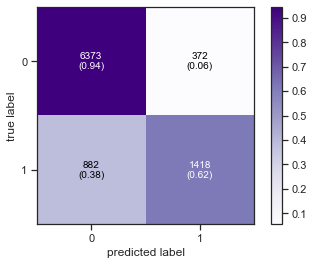

In [41]:
fig, ax = plot_confusion_matrix(conf_mat=cf_abc,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='Purples')

In [42]:
print(classification_report(y_test, abc_prediction))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6745
           1       0.79      0.62      0.69      2300

    accuracy                           0.86      9045
   macro avg       0.84      0.78      0.80      9045
weighted avg       0.86      0.86      0.86      9045



### CatBoostClassifier
CatBoost to algorytm typu "Gradient Boosting" w drzewach decyzyjnych. Opracowany przez naukowców i inżynierów Yandex jest następcą algorytmu MatrixNet, który jest szeroko stosowany w firmie do rankingowania zadań, prognozowania i formułowania rekomendacji. Jest uniwersalny i może być stosowany w wielu obszarach i przy różnych problemach.

Catboost jest zbudowany z podobnym podejściem i atrybutami jak w „starszej” generacji modeli GradientBoosting. Siła Catboost tkwi w jakościowych funkcjach przetwarzania wstępnego, czasie prognozowania i analizie modelu. Słabościami Catboost są czasy szkolenia i optymalizacji. Warto dodać paramter cat_features do obiektu klasyfikatora. Bez niego tak naprawdę nie używamy mocy Catboost. Chociaż Catboost działa dobrze z parametrami domyślnymi, istnieje kilka parametrów, które poprawiają wyniki po dostrojeniu.

In [46]:
from catboost import CatBoostClassifier

CBC = CatBoostClassifier(learning_rate=0.01,
                             depth=10,
                             eval_metric='AUC',
                             bagging_temperature = 5.4,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100,verbose=False)
model_CBC = CBC.fit(X_train, y_train)
CBC_prediction=model_CBC.predict(X_test)
cf_CBC = confusion_matrix(y_test, CBC_prediction)
print('Skuteczność dla CatBoostClassifier: ', round(accuracy_score(y_test, CBC_prediction),4)*100 , ' %')

Skuteczność dla CatBoostClassifier:  87.13  %


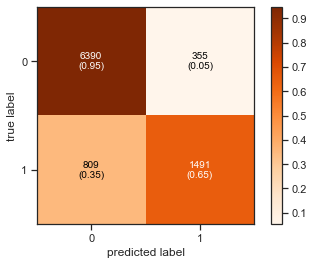

In [47]:
fig, ax = plot_confusion_matrix(conf_mat=cf_CBC,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='Oranges')

In [48]:
print(classification_report(y_test, CBC_prediction))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6745
           1       0.81      0.65      0.72      2300

    accuracy                           0.87      9045
   macro avg       0.85      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045



### XGBoost - gradient boosting algorithm
XGBoost to algorytm uczenia maszynowego oparty na drzewie decyzyjnym, który wykorzystuje strukturę "Gradient Boosting". Jeśli chodzi o małe lub średnie dane strukturalne / tabelaryczne, algorytmy oparte na drzewie decyzyjnym są obecnie uważane za najlepsze w swojej klasie. Siła algorytmu polega na jego skalowalności, która napędza szybkie uczenie się poprzez przetwarzanie równoległe i rozproszone oraz zapewnia efektywne wykorzystanie pamięci.
Extreme Gradient Boosting - obecnie jedna z najpopularniejszych metod z dziedziny data mining.

W XGBoost mamy do czynienia z zespołem klasyfikatorów, którymi mogą być modele drzew decyzyjnych. Tutaj również na ostateczną decyzję dotyczącą klasyfikacji poszczególnych obserwacji mają wpływ wszystkie drzewa użyte do budowy algorytmu.

XGBoost wykorzystuje strategię przyrostową, z uwagi na to, że jest to zadanie mniej skomplikowane i czasochłonne niż wytrenowanie wszystkich drzew jednocześnie.

Innowacją w tym podejściu jest natomiast wprowadzenie składnika regularyzacji. Regularyzacja to swego rodzaju kara nakładana na model za zbyt dużą liczbę ostatecznych segmentów obserwacji, czyli liści w drzewie decyzyjnym. W taki sposób kontrolowana jest złożoność modelu. Stąd ogólna postać algorytmu XGBoost składa się z dwóch części. Pierwszy składnik to ten odpowiadający za minimalizację błędu, nazywany funkcją straty, inaczej funkcją kosztu. Drugi zaś, czyli regularyzacja, pomaga zapobiec przetrenowaniu i kontroluje złożoność modelu.

In [50]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
model_XGB = XGB.fit(X_train, y_train)
XGB_prediction=model_XGB.predict(X_test)
cf_XGB = confusion_matrix(y_test, XGB_prediction)
print('Skuteczność dla CatBoostClassifier: ', round(accuracy_score(y_test, XGB_prediction),4)*100 , ' %')

Skuteczność dla CatBoostClassifier:  86.18  %


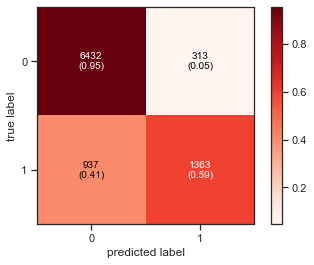

In [51]:
fig, ax = plot_confusion_matrix(conf_mat=cf_XGB,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,cmap='Reds')

### Podsumowanie

W naszym projekcie, który miał na celu zbudowanie modelu przewodującego z największą precyzją czy dana osoba zarobi więcej niż 50k USD czy mniej wykorzystaliśmy następujące modele uczenia maszynowego: 
- Decission Tree
- CatBoostClassifier
- XGBoost
- AdaBoostClassifier
- Regresja Logistyczna
- K najbliższych sąsiadów
- Support Vector Classifier
- Random Forrest 
- Naive Bayes 

Najlepszy wynik z powyższych modeli osiągnął CatBoostClassifier, wykorzystujący metodę GradientBoostingu : 
- Skuteczność na poziomie 87,13%
-  f1-score dla klasy z dochodem poniżej 50k USD __0.92__     
-  f1-score dla klasy z dochodem powyżej 50k USD __0.72__  
